In [ ]:
%pip install requests
%pip install scikit-image
%pip install pillow
%pip install tqdm

In [8]:
import requests
import urllib
import os
import threading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow, imsave
from skimage.transform import rotate
from skimage.util import img_as_ubyte, random_noise
from skimage.filters import gaussian
from tqdm import tqdm
from PIL import Image

# Get Data From API

## Download Image Data
Download images for the top 10 breeds

### Organisation of images downloaded:
The data are downloaded to `./new_dog/[breed_name]/[breed_name]_xxx.jpg` where `[breed_name]` is the dog's breed and `xxx` is a 3-digit int from 000 to 999

In [2]:
def download_imgs(breeds):
    img_count = 0

    # Not downloading if directory already exists
    if not os.path.exists('old_dog'):
        os.makedirs('old_dog')

        for breed in breeds:

            path_str = 'old_dog/' + breed
            if not os.path.exists(path_str):
                os.makedirs(path_str)

            print("Start for breed", breed)
            req_str = "https://dog.ceo/api/breed/{0}/images".format(breed)
            resp = requests.get(req_str).json()

            img_sources = resp['message']
            for i in range(len(img_sources)):

                source = img_sources[i]
                img_path = "{0}/{1}_{2:03}.jpg".format(path_str, breed, i)

                #urllib.request.urlretrieve(source, img_path)
                create_thread_for_download(source, img_path)

                img_count += 1

            print("Download all images for breed {0}.".format(breed))

        print("Success downloading all {0} images.".format(img_count))


# Use multithreading for download images
def download_by_req(source, img_path):
    urllib.request.urlretrieve(source, img_path)


def create_thread_for_download(source, img_path):
    download_thread = threading.Thread(target=download_by_req, args=(source, img_path))
    download_thread.start()

In [3]:
breed_names_used = {'bulldog', 'hound', 'mountain', 'poodle', 'retriever', 'schnauzer', 'setter', 'sheepdog', 'spaniel', 'terrier'}
breed_names_dict = {}
# download_imgs(breed_names_used)
label = 1
for breed in breed_names_used:
    breed_names_dict[breed] = label
    label += 1
print(breed_names_dict)

{'schnauzer': 1, 'hound': 2, 'terrier': 3, 'poodle': 4, 'bulldog': 5, 'setter': 6, 'spaniel': 7, 'mountain': 8, 'sheepdog': 9, 'retriever': 10}


## Generate csv containing image_name, label pairs

In [4]:
def generate_csv(breed_names_dict):
    csv_file = open("dog_data.csv", "w")
    csv_file.write("image_name,label\n")

    for breed in breed_names_dict:
        path_str = 'old_dog/' + breed
        num_files = len([f for f in os.listdir(path_str) if os.path.isfile(os.path.join(path_str, f))])
        for i in range(0, num_files):
            img_path = "{0}/{1}_{2:03}.jpg".format(path_str, breed, i)
            csv_file.write("{0},{1}\n".format(img_path, breed_names_dict[breed]))

    csv_file.close()


In [5]:
generate_csv(breed_names_dict)

# Resize all images
All images will be center-cropped and resized to dimension 224 x 224 (dimensions can be changed later)

In [6]:
# resize all images in all folders to be of the same dimension
def resize_all_imgs(breed_names_dict):
    for breed in breed_names_dict:
        path_old_str = 'old_dog/' + breed
        path_str = 'new_dog/' + breed
        if not os.path.exists(path_str):
            os.makedirs(path_str)

        num_files = len([f for f in os.listdir(path_old_str) if os.path.isfile(os.path.join(path_old_str, f))])
        for i in range(0, num_files):
            img_path_old = "{0}/{1}_{2:03}.jpg".format(path_old_str, breed, i)
            img_path = "{0}/{1}_{2:03}.jpg".format(path_str, breed, i)

            img = Image.open(img_path_old)
            size = min(img.size)
            hmargin = (img.size[0] - size) // 2
            vmargin = (img.size[1] - size) // 2
            img = img.crop((hmargin, vmargin, size+hmargin, size+vmargin))
            img = img.resize((64, 64))
            img = img.convert('RGB')
            img.save(img_path)

In [9]:
resize_all_imgs(breed_names_dict)

# Perform image augmentation to downloaded images

Augmentations include rotations, shifting, flipping and adding noise

In [10]:
data = pd.read_csv("dog_data.csv")
data.head()
all_img = []
for image_path in tqdm(data['image_name']):
    image_path = image_path.replace('old', 'new')
    img = imread(image_path)
    all_img.append(np.array(img, dtype=np.uint8))

train_x = np.stack(all_img)
train_y = data['label'].values
train_x.shape, train_y.shape

100%|██████████| 6112/6112 [00:02<00:00, 2216.10it/s]


((6112, 64, 64, 3), (6112,))

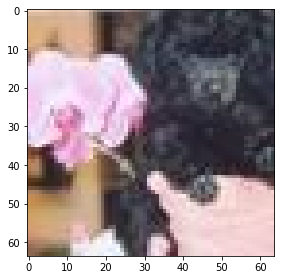

In [11]:
imshow(train_x[np.random.choice(train_x.shape[0])])

In [12]:
all_img = []
final_train_x = []
final_train_y = []

for i in tqdm(range(train_x.shape[0])):
    img, label = train_x[i], train_y[i]
    all_img.extend([
        img,
        img_as_ubyte(rotate(img, angle=45, mode='wrap')),
        np.fliplr(img),
        np.flipud(img),
        img_as_ubyte(random_noise(train_x[i],var=0.2**2))
    ])
    final_train_y.extend([train_y[i]] * 5)

final_train_x = np.stack(all_img)
final_train_y = np.array(final_train_y)
final_train_x.shape, final_train_y.shape

100%|██████████| 6112/6112 [00:17<00:00, 350.26it/s]


((30560, 64, 64, 3), (30560,))

see results of augmentation

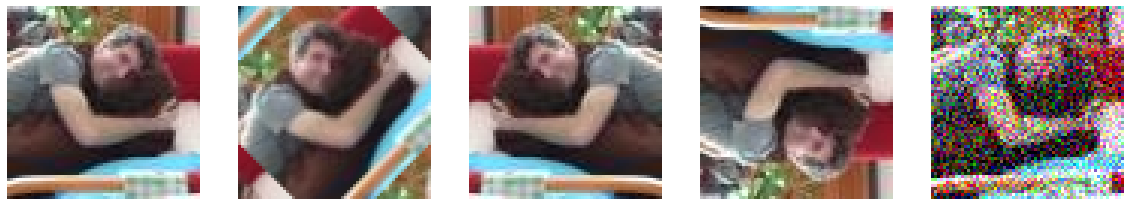

In [13]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20, 20))
idx = np.random.choice(train_x.shape[0])
for i in range(5):
    label = train_y[idx]
    ax[i].imshow(final_train_x[idx*5 + i])
    ax[i].axis('off')

#Save results as pt files

In [14]:
# decrease all elements of final_train_y by 1
final_train_y -= 1
final_train_y

array([0, 0, 0, ..., 9, 9, 9], dtype=int64)

In [15]:
import torch

tensors_data = torch.from_numpy(final_train_x).float()
tensors_data = tensors_data.permute(0, 3, 1, 2)
tensors_label = torch.from_numpy(final_train_y).long()
tensors_data.size(), tensors_label.size()

(torch.Size([30560, 3, 64, 64]), torch.Size([30560]))

In [16]:
tensors_data = tensors_data.contiguous()
tensors_data.is_contiguous()

True

In [17]:
torch.save(tensors_data, 'data/aug_data_med.pt')
torch.save(tensors_label, 'data/aug_label_med.pt')